<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
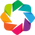

In [20]:
import os
from datetime import datetime, date
import jax

os.environ["KERAS_BACKEND"] = "jax"
import holoviews as hv
import numpy as np
import polars as pl
import tensorflow as tf
import keras_tuner as kt
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
from keras.utils import set_random_seed
from sklearn.preprocessing import StandardScaler, LabelEncoder

import temporal_fusion_transformer as tft
from temporal_fusion_transformer.src.datasets.utils import time_series_to_array
from temporal_fusion_transformer.src.datasets.air_passengers import AirPassengerPreprocessor

jax.config.update("jax_softmax_custom_jvp", True)
jax.config.update("jax_dynamic_shapes", True)
set_random_seed(222)
hv.extension("bokeh")

In [ ]:
def read_df():
    return (
        pl.read_csv("../data/air_passengers/AirPassengers.csv", try_parse_dates=True)
        .with_columns(id=0)
        .with_columns(pl.col("Month").str.to_date("%Y-%m"))
        .with_columns(pl.col("Month").dt.month_start())
        .sort("Month")
        .upsample("Month", every="1mo")
        .rename({"#Passengers": "passengers", "Month": "ts"})
    )


df = read_df()
df.head()

In [ ]:
df.plot(x="ts", y="passengers").opts(show_grid=True, width=1000, height=500)

In [ ]:
total_time_steps = 12
encoder_steps = 9

In [ ]:
def split_time_column(lf):
    return lf.with_columns(
        pl.col("ts").dt.month().alias("month"), pl.col("ts").dt.year().alias("year")
    ).drop("Month")


def split_dataset() -> tuple[pl.DataFrame, pl.DataFrame]:
    train_df_end = datetime(year=1958, month=6, day=1)
    return df.filter(pl.col("ts") <= train_df_end), df.filter(pl.col("ts") >= train_df_end)


def plot_splits(tr_df, v_df):
    data = pl.concat(
        [
            tr_df.with_columns(split=pl.lit("training")),
            v_df.with_columns(split=pl.lit("validation")),
        ]
    )
    return (
            data.plot(y="passengers", x="ts", by="split")
            * data.plot.scatter(y="passengers", x="ts", by="split", marker="asterisk")
    ).opts(show_grid=True, width=1000, height=500)


train_df, validation_df = split_dataset()
plot_splits(train_df, validation_df)

In [ ]:
preprocessor = AirPassengerPreprocessor(
    {"year": StandardScaler()}, {"passengers": StandardScaler()}, {"month": LabelEncoder()}
)
preprocessor.fit(split_time_column(df))

In [ ]:
def make_arr(lf):
    return (
        preprocessor.transform(split_time_column(lf))
        .select(["id", "year", "month", "passengers"])
        .to_numpy(order="c")
    )


train_arr = make_arr(train_df)
validation_arr = make_arr(validation_df)

In [ ]:
def timeseries_from_array_v2(x: np.ndarray, lags: int) -> np.ndarray:
    """
    Converts raw dataframe from a 2-D tabular format to a batched 3-D array to feed into Keras model.

    Parameters
    -------

    x:
        2D array.
    lags:


    Returns
    -------

    arr:
        Batched Numpy array with shape=(?, self.time_steps, self.input_size)

    """
    time_steps = len(x)
    if time_steps < lags:
        raise ValueError("time_steps < lags")
    
    return np.stack([x[i: time_steps - (lags - 1) + i, :] for i in range(lags)], axis=1)


xy_train = timeseries_from_array_v2(train_arr, total_time_steps)
xy_test = timeseries_from_array_v2(validation_arr, total_time_steps)
xy_train.shape, xy_test.shape

In [ ]:
num_inputs = 3


def make_tf_dataset(xy: np.ndarray) -> tf.data.Dataset:
    ds = (
        tf.data.Dataset.from_tensor_slices(xy)
        .map(lambda i: tf.cast(i, tf.float32), deterministic=True, num_parallel_calls=1)
        .map(
            lambda x: (x[..., :num_inputs], x[..., num_inputs:]),
            deterministic=True,
            num_parallel_calls=1,
        )
        .map(lambda x, y: (x, y[encoder_steps:]))
        .batch(8, drop_remainder=False, deterministic=True, num_parallel_calls=1)
    )
    
    return (
        ds.shuffle(ds.cardinality(), reshuffle_each_iteration=True, seed=222)
        .cache()
        .prefetch(ds.cardinality())
    )


train_ds = make_tf_dataset(xy_train)
validation_ds = make_tf_dataset(xy_test)
train_ds, validation_ds

In [ ]:
config = tft.Config(
    total_time_steps=total_time_steps,
    num_decoder_blocks=2,
    num_attention_heads=4,
    learning_rate=1e-3,
    batch_size=8,
    # id,
    input_static_idx=[0],
    # year
    input_known_real_idx=[1],
    # month
    input_known_categorical_idx=[2],
    input_observed_idx=[],
    epochs=3,
    encoder_steps=encoder_steps,
    static_categories_sizes=[1],
    known_categories_sizes=[12],
    hidden_layer_size=32,
    kernel_regularizer="L2",
)

In [ ]:
model = tft.TemporalFusionTransformer.from_dataclass_config(config)
model

In [ ]:
model.compile(
    optimizer="adam",
    loss=tft.QuantilePinballLoss(config.quantiles),
    metrics=[tft.QuantileMAPE(config.quantiles)],
    jit_compile=False,
)
model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10,
)

In [ ]:
x_test = np.asarray([*validation_ds.map(lambda x, y: x).unbatch().as_numpy_iterator()])
y_pred = model.predict(x_test, batch_size=8)

In [ ]:
x_future = x_test[:, encoder_steps:]
x_test.shape, x_future.shape

In [ ]:
def join_timestamp_column(lf: pl.DataFrame):
    ts = [date(year=int(y), month=int(m), day=1) for m, y in zip(lf["month"], lf["year"])]
    return lf.drop(["month", "year"]).with_columns(ts=pl.Series(ts))


def predictions_to_df(x_hat: np.ndarray, y_hat: np.ndarray) -> np.ndarray:
    hat_df = pl.DataFrame(
        {
            "yhat_low": time_series_to_array(y_hat[..., 0]).reshape(-1),
            "passengers": time_series_to_array(y_hat[..., 1]).reshape(-1),
            "yhat_top": time_series_to_array(y_hat[..., 2]).reshape(-1),
            "year": time_series_to_array(x_hat[..., 1:2]).reshape(-1),
            "month": np.ceil(time_series_to_array(x_hat[..., 2:3]).reshape(-1)).astype(int),
        }
    )
    hat_df = (
        preprocessor.inverse_transform(hat_df)
        .rename({"passengers": "yhat"})
        .with_columns(
            pl.col("yhat_top").map_batches(preprocessor.inverse_transform_passengers),
            pl.col("yhat_low").map_batches(preprocessor.inverse_transform_passengers),
            pl.col("year").ceil(),
        )
    )
    hat_df = join_timestamp_column(hat_df).sort("ts")
    return hat_df


pred_df = predictions_to_df(x_future, y_pred)

In [ ]:
def plot_predictions_vs_real(pr_df):
    spread = hv.Spread(
    (
        pr_df["ts"].to_numpy(),
        pr_df["yhat"].to_numpy(),
        (pr_df["yhat_top"] - pr_df["yhat"]).to_numpy(),
        (pr_df["yhat"] - pr_df["yhat_low"]).to_numpy(),
    )
)

    p1 = validation_df.plot.line(x="ts", y="passengers").opts(color="gray")
    s1 = validation_df.plot.scatter(x="ts", y="passengers").opts(color="gray")

    p2 = pr_df.plot.line(x="ts", y="yhat").opts(color="blue")
    s2 = pr_df.plot.scatter(x="ts", y="yhat").opts(color="blue")

    return (spread * p1 * s1 * p2 * s2).opts(show_grid=True, show_legend=True, width=1000, height=400)


plot_predictions_vs_real(pred_df)

#### Part2

In [22]:
def hypermodel_factory(hp: kt.HyperParameters) -> kt.HyperModel:
    
    hidden_layer_size = hp.Int("hidden_layer_size", min_value=5, max_value=500)
    dropout_rate = hp.Float("dropout_rate", min_value=0.0, max_value=0.5)
    num_attention_heads = hp.Int("num_attention_heads", min_value=2, max_value=14, step=2)
    num_decoder_blocks = hp.Int("num_decoder_blocks", min_value=1, max_value=12)
    
    #kernel_regularizer = hp.Choice("kernel_regularizer", ["L2", "L1", "None"])
    #bias_regularizer = hp.Choice("bias_regularizer", ["L2", "L1", "None"])
    #activity_regularizer = hp.Choice("activity_regularizer",  ["L2", "L1", "None"])
    #recurrent_regularizer = hp.Choice("recurrent_regularizer", ["L2", "L1", "None"])
    
    hyper_model = tft.TemporalFusionTransformer(
        input_observed_idx=config.input_observed_idx,
        input_static_idx=config.input_static_idx,
        input_known_real_idx=config.input_known_real_idx,
        input_known_categorical_idx=config.input_known_categorical_idx,
        static_categories_sizes=config.static_categories_sizes,
        known_categories_sizes=config.known_categories_sizes,
        hidden_layer_size=hidden_layer_size,
        dropout_rate=dropout_rate,
        encoder_steps=config.encoder_steps,
        num_attention_heads=num_attention_heads,
        num_decoder_blocks=num_decoder_blocks,
        num_quantiles=3,
        num_outputs=1,
        total_time_steps=config.total_time_steps,
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        recurrent_regularizer=None,
    )
    
    learning_rate = hp.Float("learning_rate", 1e-4, 5e-3, sampling="log")
    clipnorm = hp.Float("clipnorm", 0.0, 1.0)
    hyper_model.compile(
        optimizer=Adam(learning_rate, clipnorm=clipnorm),
        loss=tft.QuantilePinballLoss(config.quantiles),
        metrics=[tft.QuantileMAPE(config.quantiles)]
    )
    return hyper_model
    
    
hyperband = kt.Hyperband(
    hypermodel=hypermodel_factory,
    objective=kt.Objective("q_mape", direction="min"),
    directory="../data/tuner_logs",
    project_name="tft_airp",
)


hyperband.search(
    train_ds,
    validation_data=validation_ds,
    callbacks=[TensorBoard(log_dir="../data/logs/", write_graph=False)],
    verbose=1,
)

Trial 1 Complete [00h 00m 58s]
q_mape: 396.18701171875

Best q_mape So Far: 396.18701171875
Total elapsed time: 00h 00m 58s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
316               |495               |hidden_layer_size
0.34786           |0.18038           |dropout_rate
4                 |10                |num_attention_heads
3                 |2                 |num_decoder_blocks
0.00097684        |0.0014729         |learning_rate
0.79987           |0.84289           |clipnorm
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round
Epoch 1/2


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x106113160>>
Traceback (most recent call last):
  File "/Users/artemsereda/miniconda3/envs/py310/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 